In [1]:
import time
import pandas as pd 
import numpy as np
import pingouin as pg 
import lightgbm as lgb 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.multiclass import unique_labels
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
df = pd.read_csv('fixed_projects.csv')

In [3]:
replace_values = {'Illicit':1, 'likely-reputable':0}
# replace_values = {1:'Illicit', 0:'likely-reputable'}
df['FLAG'] = df['FLAG'].replace(replace_values)

In [4]:
X = df.drop(columns = ['Address', 'FLAG'], axis=1)
y = df['FLAG']

### Inferential Statistics

In [5]:
# Correlation between inputs 
corr_matrix = X.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

X.drop(columns=to_drop, axis=1, inplace=True)

/tmp/ipykernel_6885/4228884520.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


### Model Training

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True)

In [7]:
def stratified_k_fold_LGBM(X, Y, n_folds):
    # import matplotlib
    # matplotlib.use('Agg')
    print("Starting stratified Cross-validation using LGBM")
    #model1 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
    #                           subsample=0.8, colsample_bytree=0.8, objective='binary:logistic',
    #                           scale_pos_weight=1, seed=27)
    clf = lgb.LGBMClassifier(learning_rate=0.2)
    max_depth = [2, 3, 4, 5, 6, 7, 8]
    n_estimators = [100, 150, 200, 250, 300]
    param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=7)
    score = {'f1', 'roc_auc', 'accuracy'}
    current = time.time()
    #results = cross_validate(model1, X, Y, cv=kfold, scoring=scoring, return_train_score=True, n_jobs=-1)
    results = GridSearchCV(clf,param_grid, cv=kfold, scoring='roc_auc', n_jobs=6)
    grid_result = results.fit(X, Y)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print("Execution time: ", time.time() - current)

    # plot results
    scores = np.array(means).reshape(len(max_depth), len(n_estimators))
    for i, value in enumerate(max_depth):
        plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
    plt.legend()
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')
    plt.show()

Starting stratified Cross-validation using LGBM
Best: 0.999999 using {'max_depth': 2, 'n_estimators': 100}
0.999999 (0.000003) with: {'max_depth': 2, 'n_estimators': 100}
0.999999 (0.000003) with: {'max_depth': 2, 'n_estimators': 150}
0.999998 (0.000007) with: {'max_depth': 2, 'n_estimators': 200}
0.999998 (0.000007) with: {'max_depth': 2, 'n_estimators': 250}
0.999998 (0.000007) with: {'max_depth': 2, 'n_estimators': 300}
0.999995 (0.000014) with: {'max_depth': 3, 'n_estimators': 100}
0.999995 (0.000014) with: {'max_depth': 3, 'n_estimators': 150}
0.999997 (0.000010) with: {'max_depth': 3, 'n_estimators': 200}
0.999997 (0.000010) with: {'max_depth': 3, 'n_estimators': 250}
0.999997 (0.000010) with: {'max_depth': 3, 'n_estimators': 300}
0.999997 (0.000010) with: {'max_depth': 4, 'n_estimators': 100}
0.999997 (0.000010) with: {'max_depth': 4, 'n_estimators': 150}
0.999995 (0.000014) with: {'max_depth': 4, 'n_estimators': 200}
0.999997 (0.000010) with: {'max_depth': 4, 'n_estimators': 25

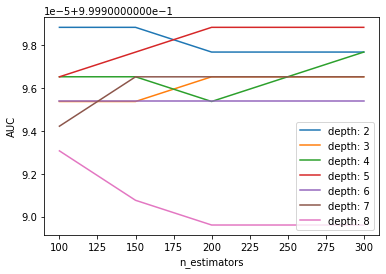

In [8]:
stratified_k_fold_LGBM(X, y, 10)

/home/malik_cyrus/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/malik_cyrus/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's binary_error: 0.346484	training's binary_logloss: 0.561783	valid_1's binary_error: 0.371413	valid_1's binary_logloss: 0.574633
[2]	training's binary_error: 0.346484	training's binary_logloss: 0.494342	valid_1's binary_error: 0.371413	valid_1's binary_logloss: 0.504936
[3]	training's binary_error: 0.0299373	training's binary_logloss: 0.43835	valid_1's binary_error: 0.0265295	valid_1's binary_logloss: 0.44711
[4]	training's binary_error: 0.0104433	training's binary_logloss: 0.391174	valid_1's binary_error: 0.0086627	valid_1's binary_logloss: 0.39853
[5]	training's binary_error: 0.0102112	training's binary_logloss: 0.34959	valid_1's binary_error: 0.00703844	valid_1's binary_logloss: 0.355807
[6]	training's binary_error: 0.00742632	training's binary_logloss: 0.313859	valid_1's binary_error: 0.00487277	valid_1's binary_logloss: 0.318959
[7]	training's binary_error: 0.00394523	training's binary_logloss: 0.282212	valid_1's binary_error: 0.00270709	valid_1's binary_logloss: 0.28

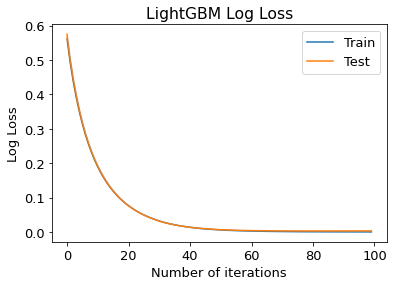

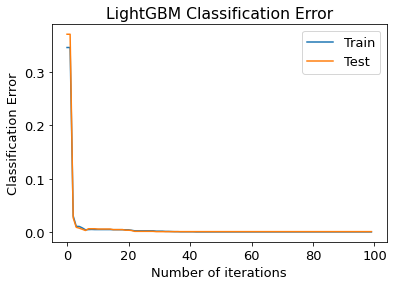

In [9]:
clf = lgb.LGBMClassifier(learning_rate=0.09,
                            max_depth=8,
                            subsample=0.5, 
                            objective='binary',
                            n_estimators=100)
eval_set = [(X_train, y_train), (X_test, y_test)]
# clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric=["error", "logloss"],
#           eval_set=eval_set, verbose=True)
clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric=["error", "logloss"],
              eval_set=eval_set, verbose=True)

# predict
y_pred = clf.predict(X_test)
predicted_values = [round(val) for val in y_pred]

# evaluation 
accuracy = accuracy_score(y_test, predicted_values)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print(classification_report(y_test, y_pred, digits=4))

# performance metrics 
results = clf.evals_result_
epochs = len(results['training']['binary_error'])
x_axis = range(0, epochs)
plt.rcParams.update({'font.size': 13})

# plotting log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['training']['binary_logloss'], label='Train')
ax.plot(x_axis, results['valid_1']['binary_logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('Number of iterations')
plt.title('LightGBM Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['training']['binary_error'], label='Train')
ax.plot(x_axis, results['valid_1']['binary_error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.xlabel('Number of iterations')
plt.title('LightGBM Classification Error')
plt.show()

In [10]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9991    0.9996      1161
           1     0.9985    1.0000    0.9993       686

    accuracy                         0.9995      1847
   macro avg     0.9993    0.9996    0.9994      1847
weighted avg     0.9995    0.9995    0.9995      1847



### Confusion Matrix

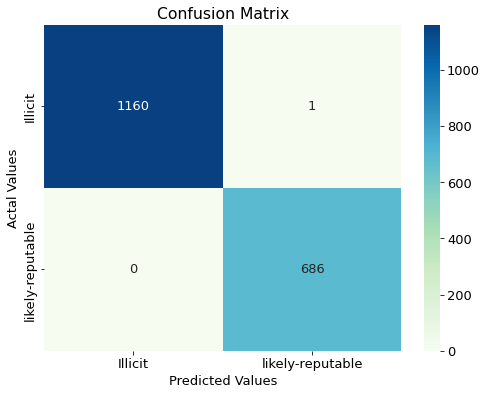

In [11]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Illicit', 'likely-reputable'], 
                     columns = ['Illicit', 'likely-reputable'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='GnBu')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

### Random Forest Classifier

In [12]:

rfc = RandomForestClassifier()
rfc_model = rfc.fit(X_train, y_train)
pred8 = rfc_model.predict(X_test)
print("Accuracy for Random Forest Model: %.2f" % (accuracy_score(y_test, pred8) * 100))
print(classification_report(y_test, pred8, digits=4))
roc = roc_auc_score(y_test, rfc_model.predict_proba(X_test)[:, 1])
print("ROC:" , roc)

Accuracy for Random Forest Model: 99.84
              precision    recall  f1-score   support

           0     0.9983    0.9991    0.9987      1161
           1     0.9985    0.9971    0.9978       686

    accuracy                         0.9984      1847
   macro avg     0.9984    0.9981    0.9983      1847
weighted avg     0.9984    0.9984    0.9984      1847

ROC: 0.9999937221104758


### Logistic Regression for Classification

In [13]:
#  normalizing data set 
X_train_reg = StandardScaler().fit_transform(X_train)
X_test_reg = StandardScaler().fit_transform(X_test)


In [14]:
lgr = LogisticRegression(max_iter=100000)
lgr.fit(X_train_reg, y_train)

y_pred_reg = lgr.predict(X_test_reg)
print("Accuracy of logistic regression classifier on test set: {:.4f}".format(accuracy_score(y_test, y_pred_reg)))

Accuracy of logistic regression classifier on test set: 0.9155


In [15]:
print("Accuracy of logistic regression classifier on test set: {:.4f}".format(accuracy_score(y_test, y_pred_reg)))

Accuracy of logistic regression classifier on test set: 0.9155


In [16]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_reg)
metrics.auc(fpr, tpr)

0.9307291392009001

In [17]:
cfm = confusion_matrix(y_test, y_pred)
print(cfm)

[[1160    1]
 [   0  686]]


In [18]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9991    0.9996      1161
           1     0.9985    1.0000    0.9993       686

    accuracy                         0.9995      1847
   macro avg     0.9993    0.9996    0.9994      1847
weighted avg     0.9995    0.9995    0.9995      1847



### Predict Probability using LGBM

In [19]:
prob_of_projects = clf.predict_proba(df.drop(columns = ['Address', 'FLAG','Unique_Received_From_Addresses',
                                                        'avg_val_received','avg_val_sent', 'ERC20_total_Ether_received',
                                                        'ERC20_total_Ether_sent_contract', 'ERC20_avg_time_between_contract_tnx', 'ERC20_max_val_rec',
                                                        'ERC20_avg_val_rec', 'ERC20_min_val_sent', 'ERC20_max_val_sent', 'ERC20_avg_val_sent',
                                                        'ERC20_uniq_rec_token_name'], axis=1)) 

In [20]:
df['prob_reputable'] = prob_of_projects[:, 0]
df['prob_illicit'] = prob_of_projects[:, 1]

In [21]:
df

,Address,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Sent_tnx,Received_Tnx,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,...,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name,prob_reputable,prob_illicit
0,0x0020731604c882cf7bf8c444be97d17b19ea4316,1,1457.31,34.120000,3.0,13.0,10.0,3.0,1.000000,2.501052,...,1.337000e+00,1.337000e+01,1.337000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0,0.012862,0.987138
1,0x002bf459dc58584d58886169ea0e80f3ca95ffaf,1,3976.50,834.770000,2.0,2.0,1.0,2.0,0.586269,0.947515,...,1.337000e+00,1.337000e+00,1.337000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0,0.012965,0.987035
2,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,1,112.90,31.870000,2.0,3.0,3.0,1.0,0.001020,0.817800,...,1.337000e+00,1.337000e+00,1.337000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0,0.012965,0.987035
3,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,1,2300.37,65.100000,29.0,98.0,89.0,26.0,0.000784,15.729068,...,0.000000e+00,2.643608e+04,1.954485e+03,0.000000e+00,8.132407e+04,5.232816e+03,22.0,37.0,0.033476,0.966524
4,0x005b9f4516f8e640bbe48136901738b323c53b00,1,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1.337000e+00,1.337000e+01,1.337000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0,0.012977,0.987023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6151,0x0ec78ed49c2d27b315d462d43b5bab94d2c79bf8,0,0.00,55.472184,0.0,0.0,0.0,0.0,0.000008,224.672822,...,1.000000e+02,1.000000e+02,1.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0,0.992911,0.007089
6152,0xcbc1aa6961b28cccb11e1cddd84ad8b42ec920b1,0,0.00,55.472184,0.0,0.0,0.0,0.0,0.000008,224.672822,...,4.400000e-17,2.320000e-11,2.132394e-14,7.200000e-17,2.320000e-11,4.119184e-14,1.0,1.0,0.992911,0.007089
6153,0xa4ef4b0b23c1fc81d3f9ecf93510e64f58a4a016,0,0.00,55.472184,0.0,0.0,0.0,0.0,0.000008,224.672822,...,1.510603e+02,1.812000e+03,9.815301e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.0,2.0,0.992911,0.007089
6154,0x033e223870f766644f7f7a4b7dc2e91573707d06,0,0.00,55.472184,0.0,0.0,0.0,0.0,0.000008,224.672822,...,6.900000e-08,6.900000e-08,6.900000e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0,0.992910,0.007090


### Feature Importance

In [47]:
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 2)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    # plt.savefig('lgbm_importances-01.png')
    plt.show()

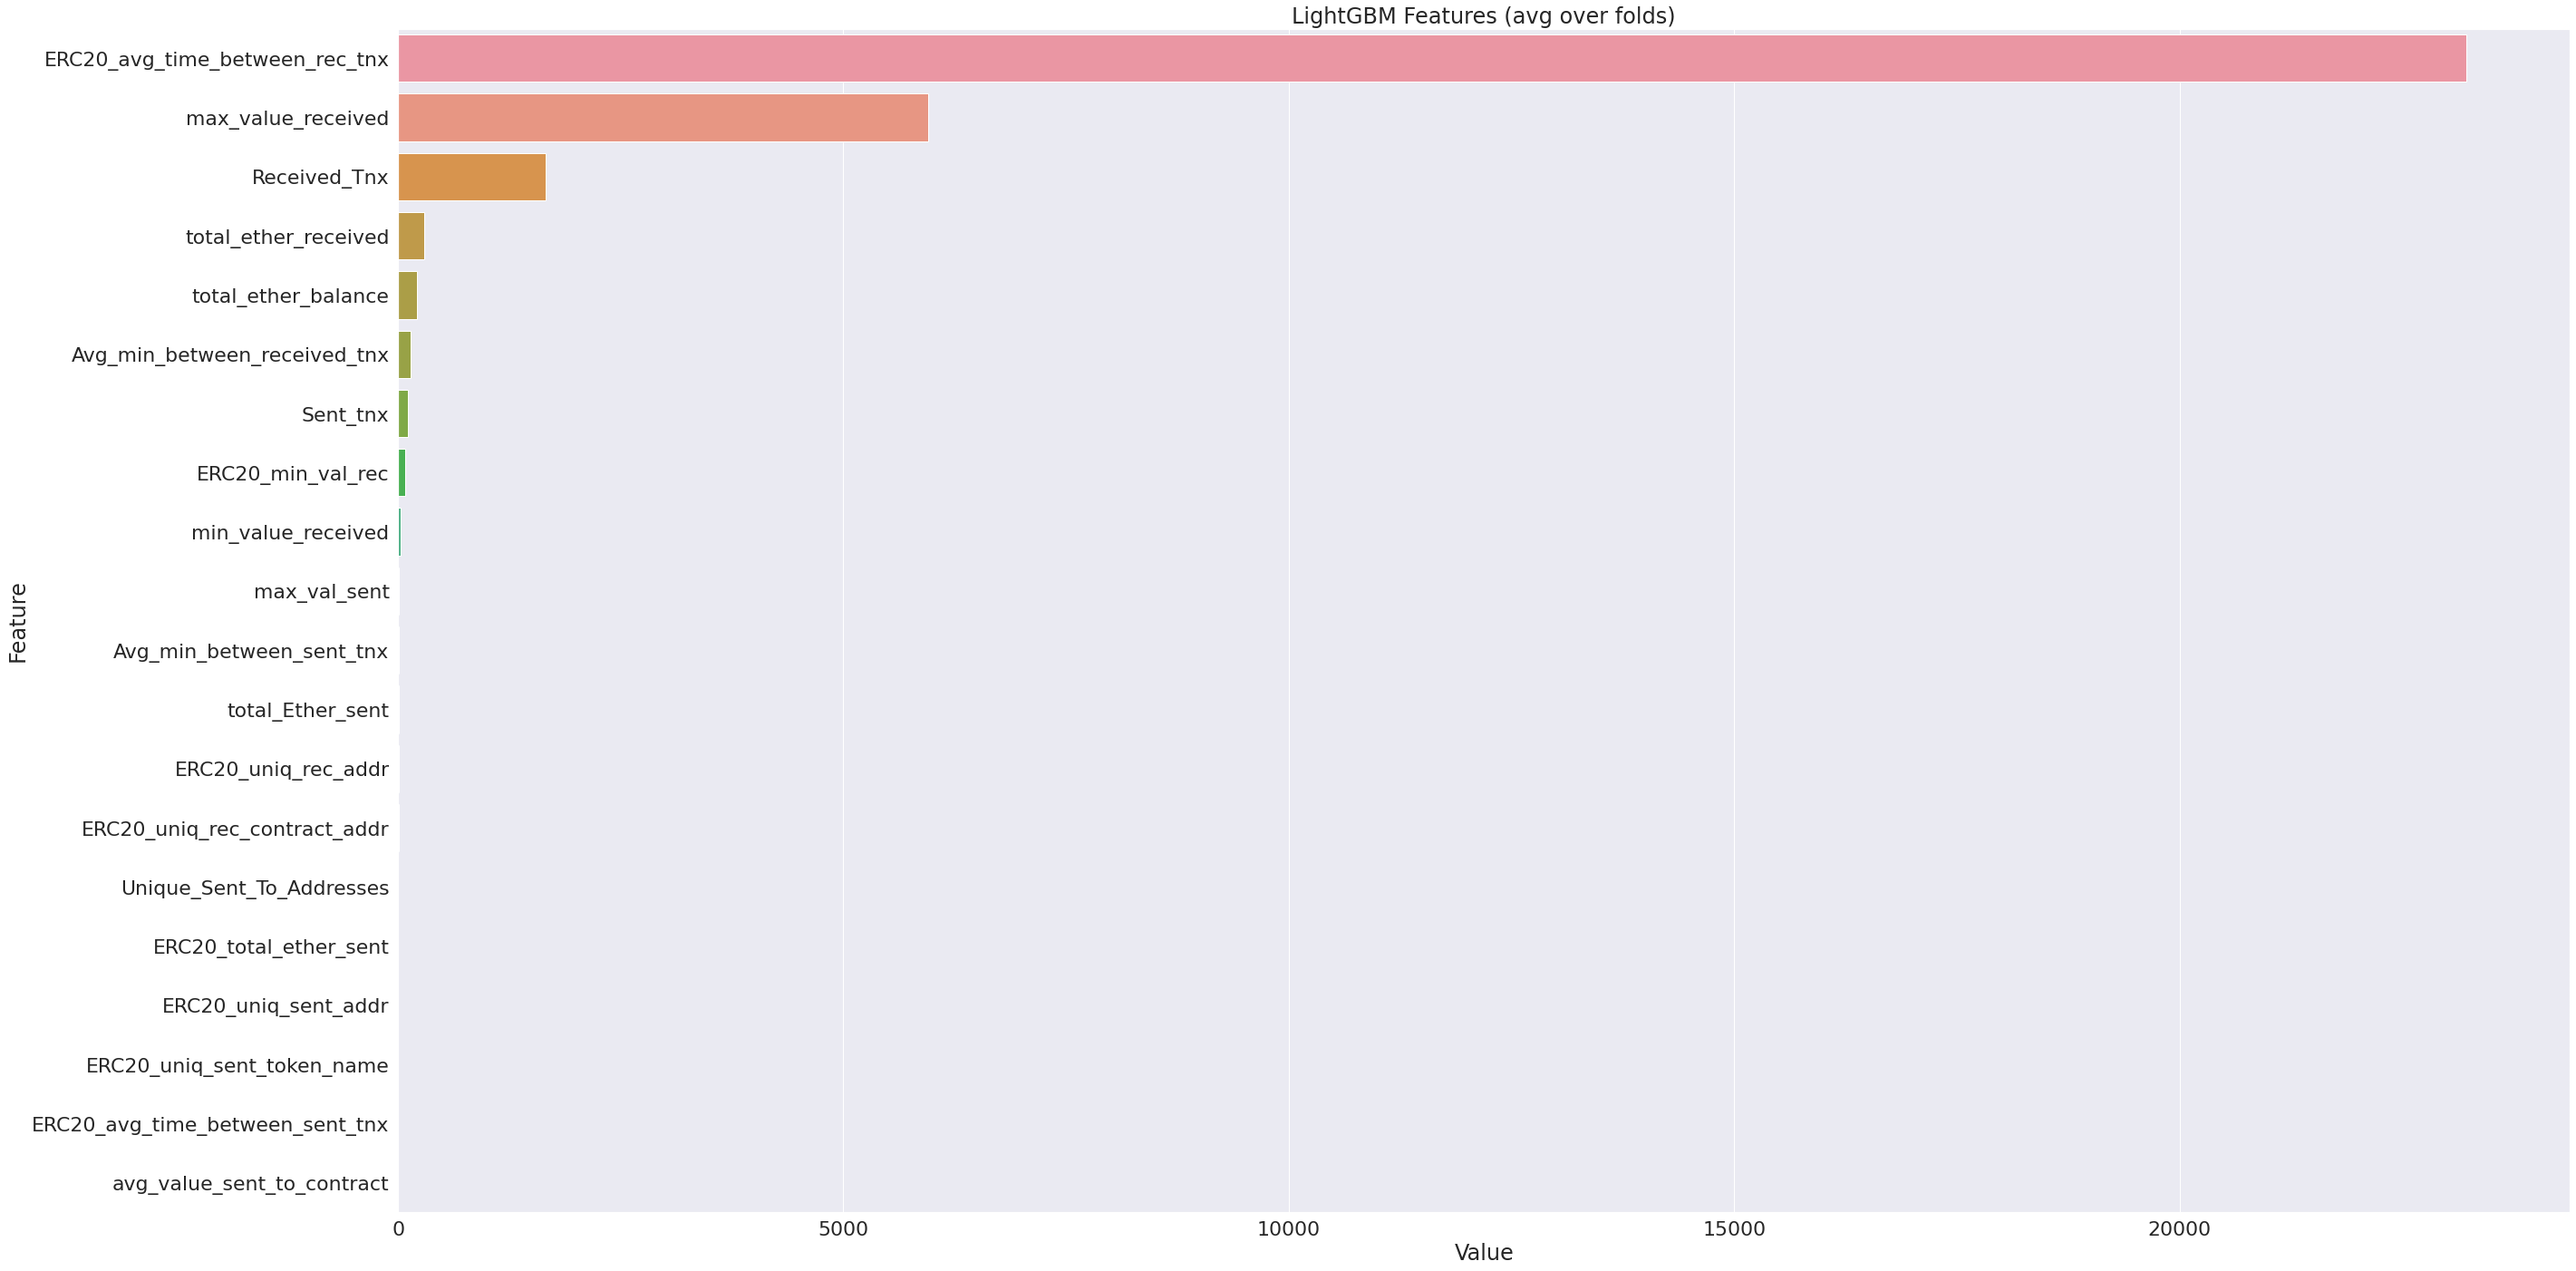

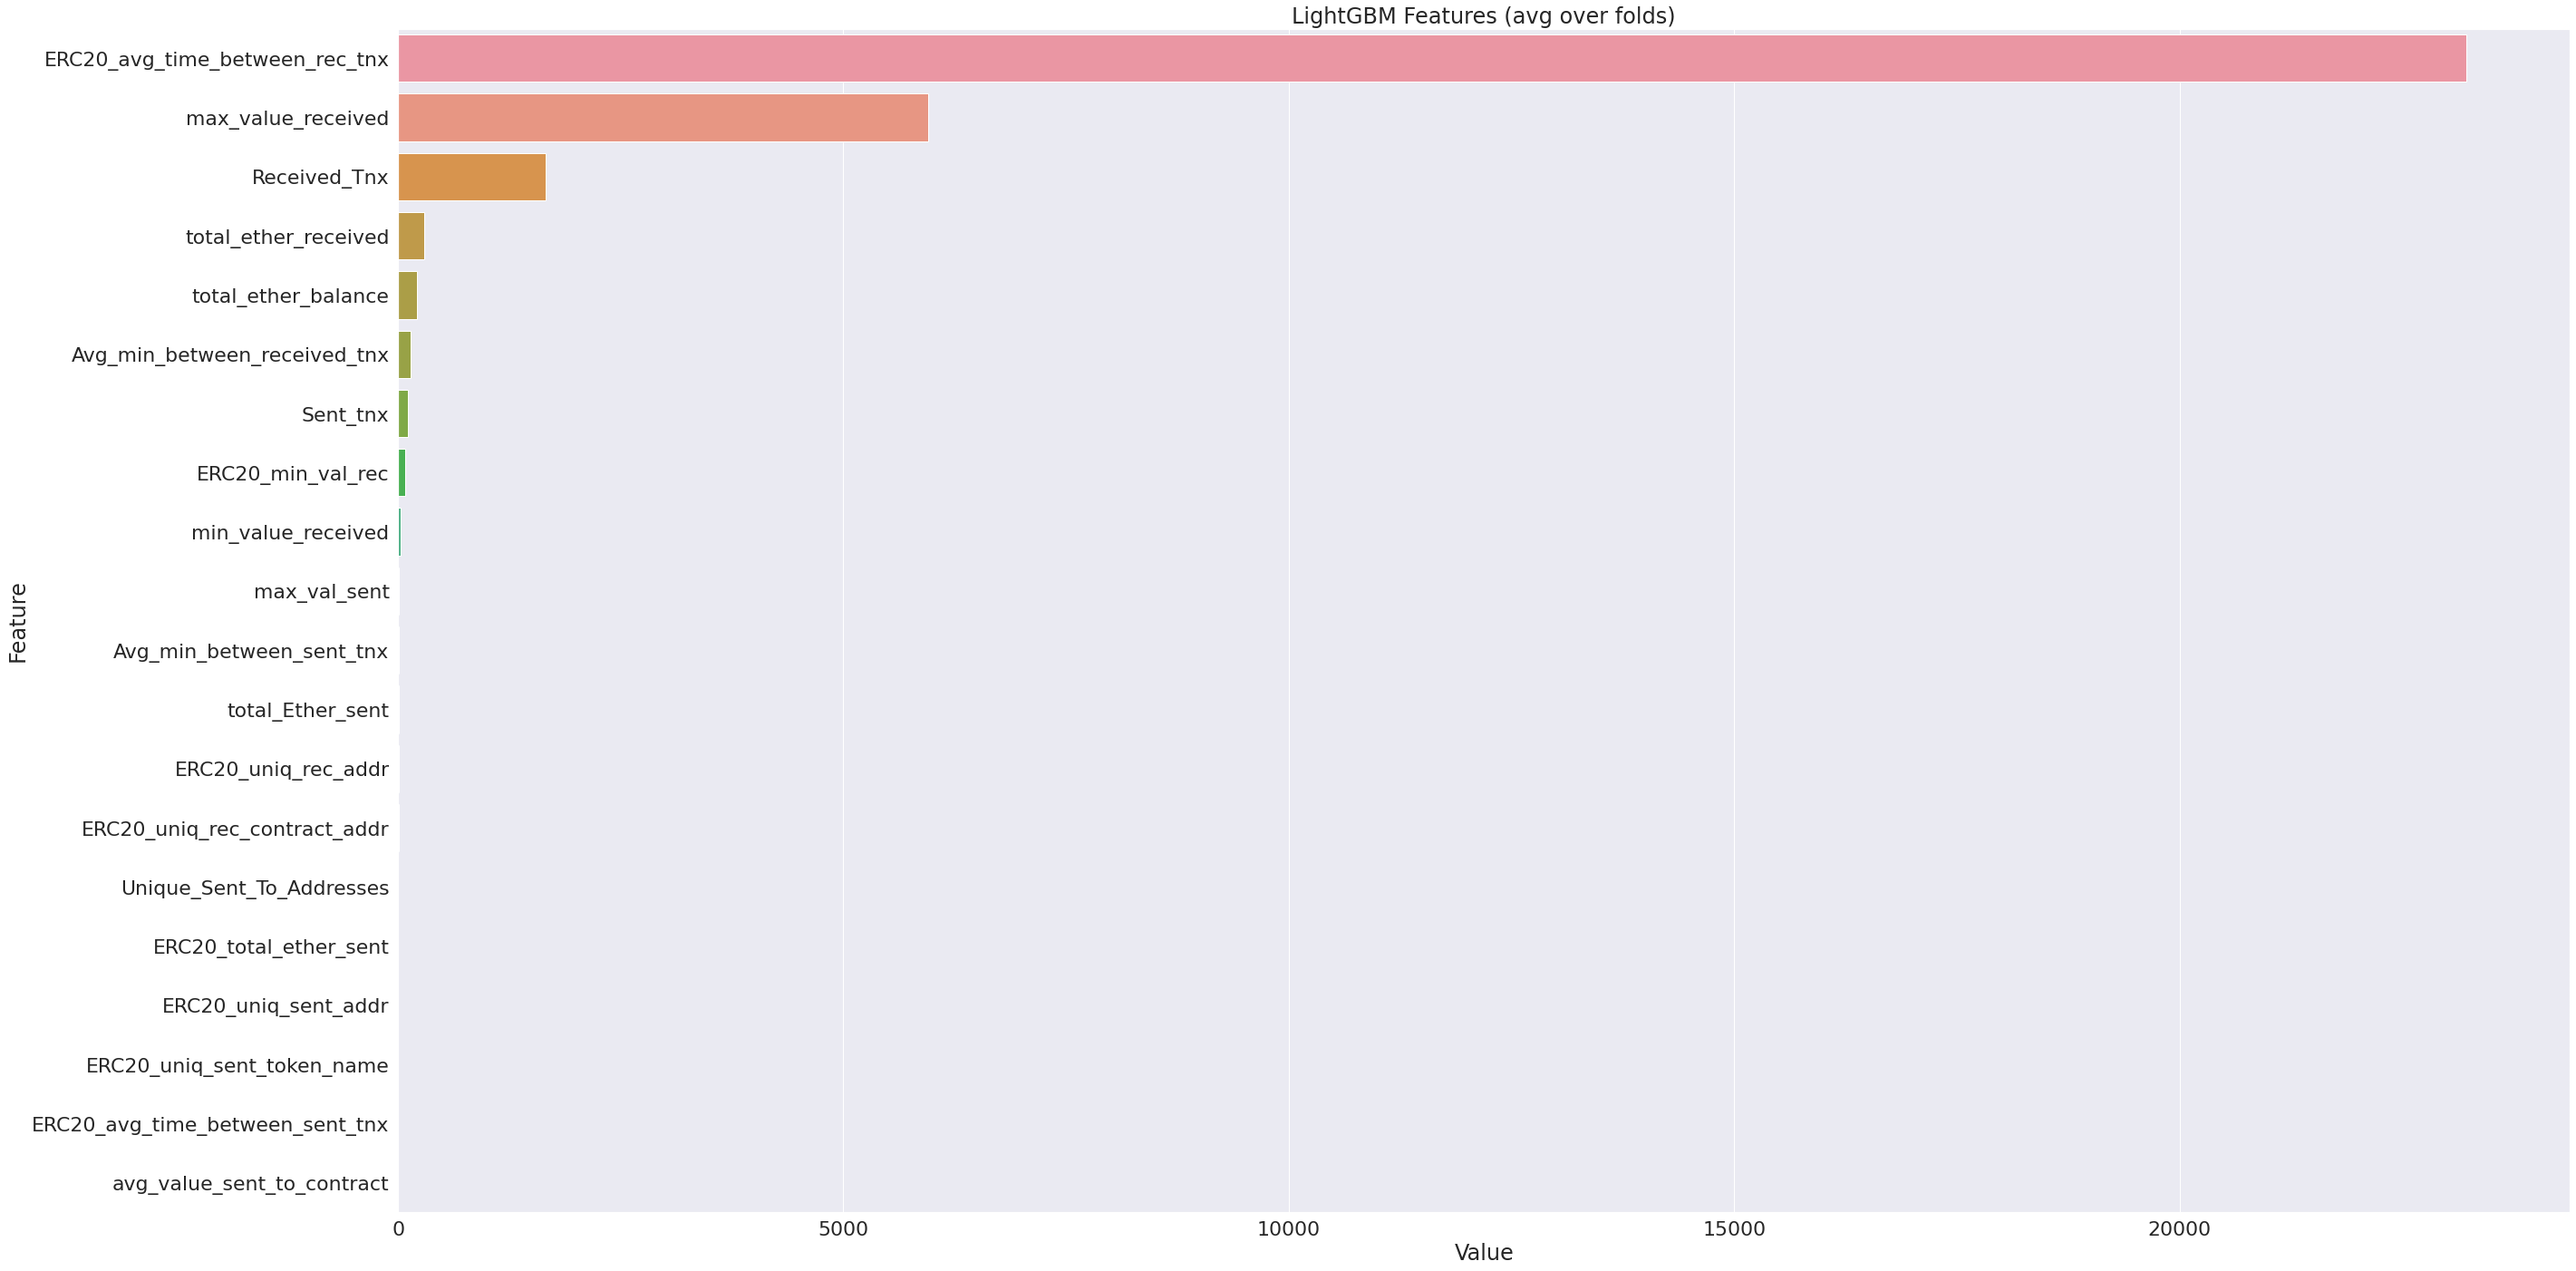

In [48]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True)
# clf = lgb.LGBMClassifier(learning_rate=0.09,
#                             max_depth=2,
#                             subsample=0.5, 
#                             objective='binary',
#                             n_estimators=100)
# eval_set = [(X_train, y_train), (X_test, y_test)]
# clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric=["error", "logloss"],
#               eval_set=eval_set, verbose=True)

# # predict
# y_pred = clf.predict(X_test)
# predicted_values = [round(val) for val in y_pred]

# # evaluation 
# accuracy = accuracy_score(y_test, predicted_values)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
clf.importance_type = 'split'
plotImp(clf, X)
# plt.savefig('feature_importance_gain.png')

clf.importance_type = 'gain'
plotImp(clf, X)
# plt.savefig('feature_importance_gain.png')